In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import joblib

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics.pairwise import distance_metrics

import os

RANDOM_SEED = 42

In [119]:
%%time
base = pd.read_csv('base.csv', index_col=0)

CPU times: total: 24.9 s
Wall time: 32.9 s


In [120]:
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
validation_answer = pd.read_csv('validation_answer.csv')

In [4]:
base.describe().loc[['min','max']].T.agg({
    'min': min,
    'max': max
})

min   -1297.931468
max    1557.433380
dtype: float64

In [5]:
train.describe().loc[['min','max']].T.agg({
    'min': min,
    'max': max
})

min   -1297.871984
max    1557.383334
dtype: float64

`float16` can be used as a column type

In [137]:
class FloatingTransrofmer(BaseEstimator, TransformerMixin):
#     __slots__ = ("bits")
    
    def __init__(self, category):
        if category not in [8,16,32,64]:
            raise Exception("Error value")
        self.bits = category
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, df):
        bits_dict = {
        8 : 'float8',
        16 : 'float16',
        32 : 'float32',
        64 : 'float64'
    }
        tmp_df = df.copy()
        tmp_df = pd.DataFrame(data=tmp_df,
                            columns=[str(item) for item in range(0,72)])
        d_type = bits_dict[self.bits]
        col_names = tmp_df.select_dtypes(exclude='object')
        for col in col_names:
            tmp_df[col] = tmp_df[col].astype(d_type)
        return tmp_df

In [127]:
flt = FloatingTransrofmer(16)
train = flt.transform(train)
base = flt.transform(base)

Metric - accuracy top-5. 

In [8]:
base_index = {k: v for k, v in enumerate(base.index.tolist())}

def accuracy_top_5(pred_list: list, real_answers: list, p=False) -> float:
    acc = 0
    if not p:
        for five_list, answer in zip(pred_list, real_answers):
            acc += int(answer in [base_index.get(el, -1) for el in five_list])
    else:
        for five_list, answer in zip(pred_list, real_answers):
            acc += int(answer in five_list)
    
    return (100 * acc / len(real_answers))

In [9]:
custom_scorer = make_scorer(accuracy_top_5, greater_is_better=True)

In [10]:
train.set_index(train['Id'], inplace=True)
train.drop(columns=['Id'], inplace=True)

train_feat = train.drop(columns=['Target'])
train_target = train['Target']

## Baseline

In [11]:
dims = base.shape[1]
n_cells = 40

quantizer = faiss.IndexFlatL2(dims)
index_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

index_l2.train(np.ascontiguousarray(base.values[:50000, :]))
index_l2.add(np.ascontiguousarray(base.values))

In [12]:
vec, idx = index_l2.search(np.ascontiguousarray(train_feat.values), 5)

initial_score = accuracy_top_5(idx.tolist(), train_target.values.tolist())
print(f'Base score: {initial_score}')

Base score: 9.354


## Distribution

In [13]:
cat_col = base.columns

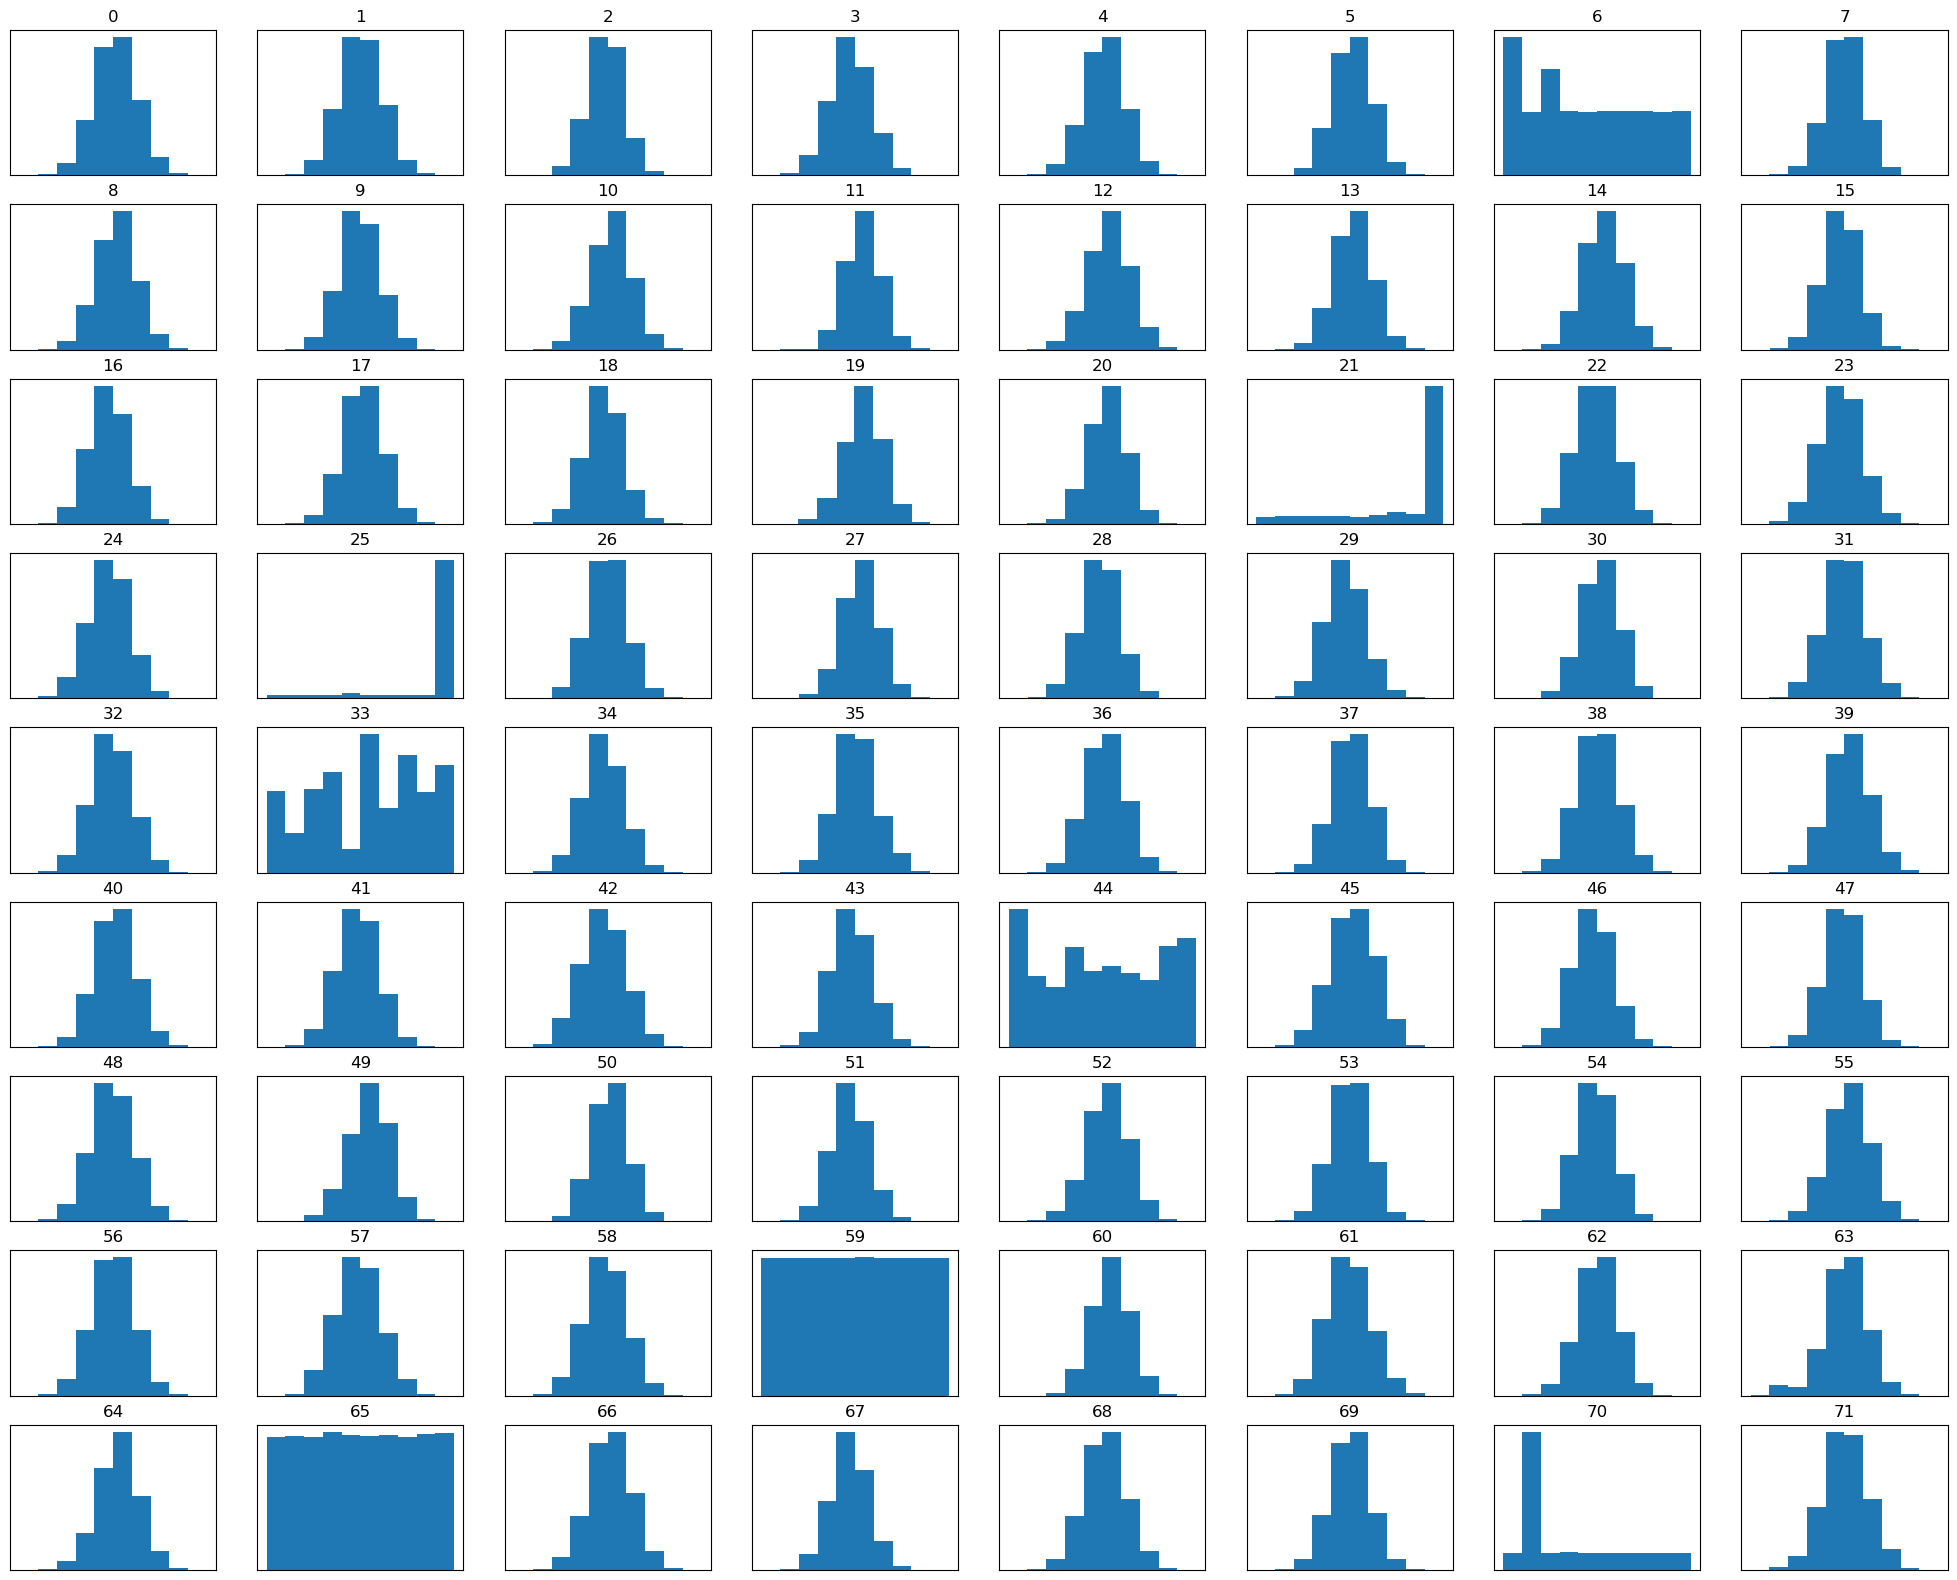

In [14]:
fig, ax = plt.subplots(nrows=9, ncols=8, figsize=(25,20))
for i in range(9):
    for j in range(8):
        ax[i,j].set_title(str(i*8+j))
        ax[i,j].hist(base[str(i*8+j)])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

In [15]:
#feature 44,59, 65 - uniform distribution
#features 6,21,25,33,70 - unclear

In [16]:
list_non_normal = ['6','21','25','33','44','59','65','70']

PCA can be used to features with a normal distribution

In [17]:
normal_base = base.copy()
normal_train = train_feat.copy()

Before we are using PCA, the data should be normalized

In [18]:
stand_scaler = StandardScaler()

normal_scaled_base = stand_scaler.fit_transform(normal_base)
normal_scaled_train = stand_scaler.transform(normal_train)

In [19]:
base_df = pd.DataFrame(data=normal_scaled_base,
                          columns=base.columns,
                          index=base.index)

train_df = pd.DataFrame(data=normal_scaled_train,
                           columns=train_feat.columns,
                           index=train_feat.index)

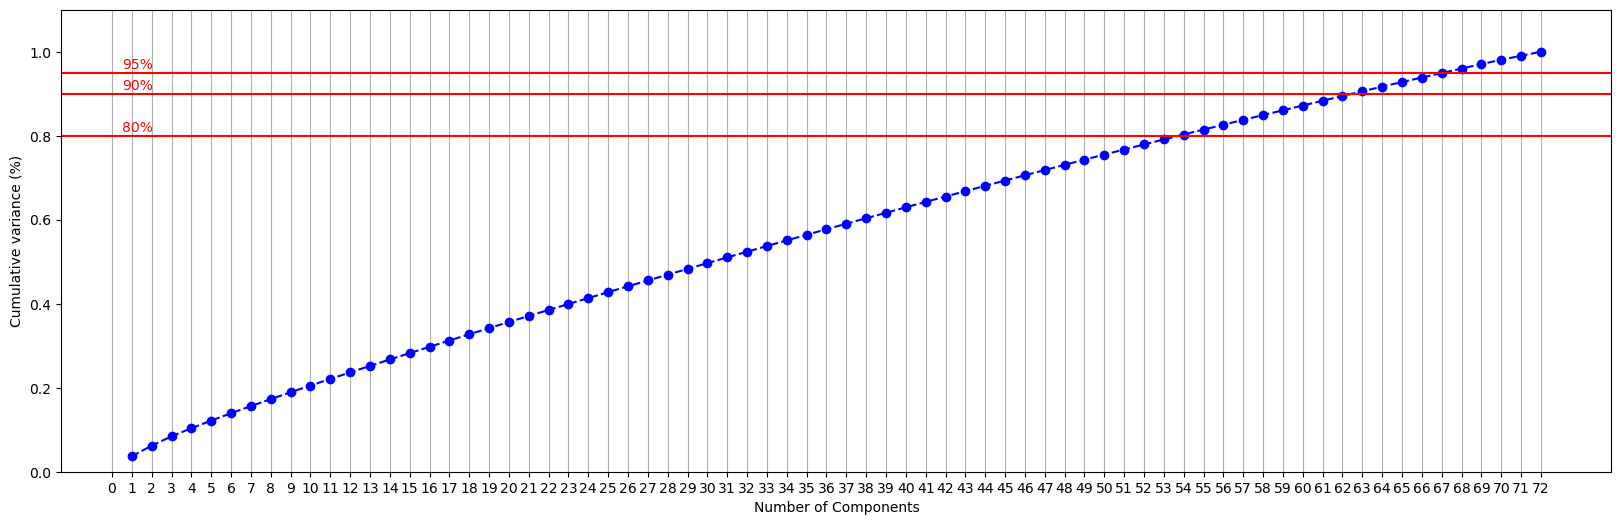

In [20]:
pca = PCA().fit(normal_scaled_base)


plt.rcParams["figure.figsize"] = (20,6)

fig, ax = plt.subplots()
xi = np.arange(1, 73, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 73, step=1)) 
plt.ylabel('Cumulative variance (%)')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.96, '95%', color = 'red', fontsize=10)

plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.91, '90%', color = 'red', fontsize=10)

plt.axhline(y=0.80, color='r', linestyle='-')
plt.text(0.5, 0.81, '80%', color = 'red', fontsize=10)

ax.grid(axis='x')
plt.show()

In [21]:
pca_param = 67
pca = PCA(n_components=pca_param)
base_pca = pca.fit_transform(normal_scaled_base)
train_pca = pca.transform(normal_scaled_train)

# base_pca_df = pd.DataFrame(data=base_pca,
#                           columns=[str(el) for el in range(1,pca_param+1)],
#                           index=base.index)
# train_pca_df = pd.DataFrame(data=train_pca,
#                            columns=[str(el) for el in range(1,pca_param+1)],
#                            index=train.index)

In [22]:
dims = base_pca.shape[1]
n_cells = 45

quantizer = faiss.IndexFlatL2(dims)
index_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

index_l2.train(np.ascontiguousarray(base_pca[:300000, :]))
index_l2.add(np.ascontiguousarray(base_pca))

index_l2.nprobe = 12

In [23]:
vec, idx = index_l2.search(np.ascontiguousarray(train_pca), 5)

score = accuracy_top_5(idx.tolist(), train_target.values.tolist())
print(f'score: {score}')

score: 65.255


## Usual Index without non-normal distributed features

In [141]:
class Droper(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.list_non_normal = ['6','21','25','33','44','59','65','70']
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        tmp_X = X.copy()
        tmp_X = pd.DataFrame(data=tmp_X,
                            columns=[str(item) for item in range(0,72)])
        tmp_X.drop(columns=self.list_non_normal, inplace=True)
        col_names = tmp_X.select_dtypes(exclude='object')
        for col in col_names:
            tmp_X[col] = tmp_X[col].astype('float16')
        return tmp_X

In [26]:
d = Droper()
dist_base = d.transform(base_df)
dist_train = d.transform(train_df)

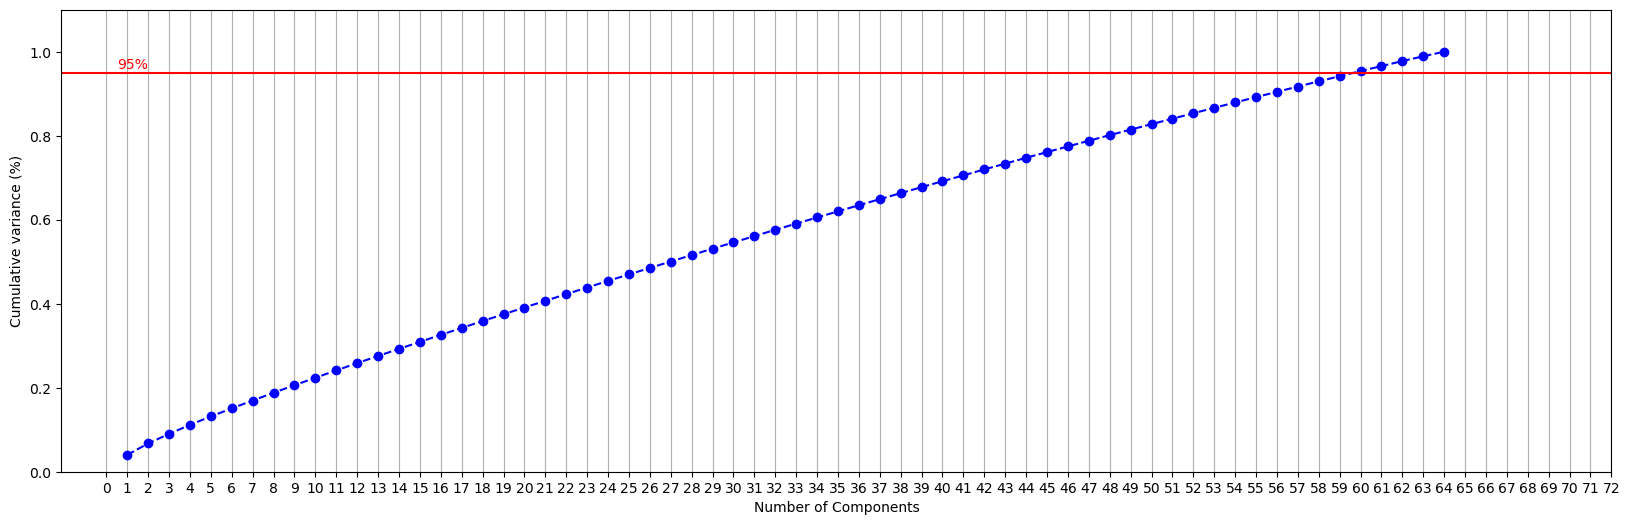

In [27]:
pca = PCA().fit(dist_base.values)


plt.rcParams["figure.figsize"] = (20,6)

fig, ax = plt.subplots()
xi = np.arange(1, dist_base.shape[1]+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 73, step=1)) 
plt.ylabel('Cumulative variance (%)')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.96, '95%', color = 'red', fontsize=10)

ax.grid(axis='x')
plt.show()

57 features

In [28]:
pca_param = 57
pca = PCA(n_components=pca_param)
base_pca = pca.fit_transform(dist_base)
train_pca = pca.transform(dist_train)

In [88]:
class Faisser(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.dims = X.shape[1]
        self.n_cells = 45
        self.quantizer = faiss.IndexFlatL2(self.dims)
        
        self.model = faiss.IndexIVFFlat(self.quantizer, self.dims, self.n_cells)
        #training
        self.model.train(np.ascontiguousarray(X[:500000, :]))
        self.model.add(np.ascontiguousarray(X))
        
        self.model.nprobe = 12
        
    def predict(self, X):
        vec, idx = self.model.search(np.ascontiguousarray(X), 5)
        return idx

In [29]:
dims = base_pca.shape[1]
n_cells = 45

quantizer = faiss.IndexFlatL2(dims)
index_l2_pca = faiss.IndexIVFFlat(quantizer, dims, n_cells)

index_l2_pca.train(np.ascontiguousarray(base_pca[:500000, :]))
index_l2_pca.add(np.ascontiguousarray(base_pca))

index_l2_pca.nprobe = 12

In [30]:
vec, idx = index_l2_pca.search(np.ascontiguousarray(train_pca), 5)

score = accuracy_top_5(idx.tolist(), train_target.values.tolist())
print(f'Score: {score}')

Score: 70.623


In [142]:
pipe = Pipeline([
    ("Scaler", StandardScaler()),
    ("Droper", Droper()),
    ("PCA", PCA(n_components=57)),
    ("Faiss", Faisser())
])

In [101]:
new_base = pd.read_csv('base.csv', index_col=0)

In [143]:
pipe.fit(new_base)

Pipeline(steps=[('Scaler', StandardScaler()), ('Droper', Droper()),
                ('PCA', PCA(n_components=57)), ('Faiss', Faisser())])

In [157]:
joblib.dump([pipe, base_index], 'faiss_pipe.joblib')

['faiss_pipe.joblib']

In [160]:
joblib.dump([Droper(), Faisser()], 'droper_faisser.joblib')

['droper_faisser.joblib']